## Import dependencies used in entire notebook

In [1]:
import dask.dataframe as dd
import numpy as np
import pandas as pd

from pathlib import Path

## Connect to database and import data

In [ ]:
# Import engine to make connection to database

from sqlalchemy import create_engine

In [ ]:
# Connect to Flights_DB

db_path = Path('Resources/Flights_DB.sqlite')
engine = create_engine(f'sqlite:///{db_path}')

conn = engine.connect()

In [ ]:
# Load Flights table, join Cancelled_Flights and Delayed_Flights for reasons

flights_df = pd.read_sql_query('''
                                  SELECT F.Operating_Airline
                                      ,F.Origin_Airport
                                      ,F.Destination_Airport
                                      ,F.Flight_Date
                                      ,F.Scheduled_Arrival_Time
                                      ,F.Scheduled_Departure_Time
                                      ,D.Carrier_Delay_Minutes
                                      ,D.Weather_Delay_Minutes
                                      ,D.NAS_Delay_Minutes
                                      ,D.Security_Delay_Minutes
                                      ,D.Late_Aircraft_Delay_Minutes
                                      ,C.Cancellation_Code
                                      ,F.Target
                                  FROM Flights F
                                  LEFT JOIN Cancelled_Flights C ON F.ID = C.ID
                                  LEFT JOIN Delayed_Flights D ON F.ID = D.ID
                               ''',
                               con=engine,
                               dtype={
                                   'Operating_Airline': object,
                                   'Origin_Airport': object,
                                   'Destination_Airport': object,
                                   'Flight_Date': np.datetime64,
                                   'Scheduled_Arrival_Time': np.datetime64,
                                   'Scheduled_Departure_Time': np.datetime64,
                                   'Carrier_Delay_Minutes': object,
                                   'Weather_Delay_Minutes': object,
                                   'NAS_Delay_Minutes': object,
                                   'Security_Delay_Minutes': object,
                                   'Late_Aircraft_Delay_Minutes': object,
                                   'Cancellation_Code': object,
                                   'Target': np.int32
                               })

flights_df.head(10)

In [ ]:
# Checking to make sure timedeltas have values

flights_df.nunique()

## Preprocessing

In [ ]:
# Make separate columns for Month, Day and Weekday

flights_df['Month'] = flights_df['Flight_Date'].dt.month
flights_df['Day'] = flights_df['Flight_Date'].dt.day
flights_df['Weekday'] = flights_df['Flight_Date'].dt.dayofweek

flights_df.head(10)

In [ ]:
# Extract hour from arrival/departure columns

time_columns = ['Scheduled_Arrival_Time', 'Scheduled_Departure_Time']

for col in time_columns:
    flights_df[col] = flights_df[col].dt.hour

In [ ]:
# Fill None in intervals with 0

none_cols = ['Carrier_Delay_Minutes', 'Weather_Delay_Minutes', 'NAS_Delay_Minutes',
                 'Security_Delay_Minutes', 'Late_Aircraft_Delay_Minutes', 'Cancellation_Code']

flights_df[none_cols] = flights_df[none_cols].apply(lambda x: x.fillna(0))

flights_df.head(10)

In [ ]:
# Double check existence of nulls

flights_df.isna().sum()

In [ ]:
# Drop Flight_Date column

flights_df = flights_df.drop(columns='Flight_Date')

flights_df.head(10)

In [ ]:
# Extract numbers from Minutes column string

interval_cols = ['Carrier_Delay_Minutes', 'Weather_Delay_Minutes', 'NAS_Delay_Minutes',
                 'Security_Delay_Minutes', 'Late_Aircraft_Delay_Minutes']

flights_df[interval_cols] = flights_df[interval_cols].apply(lambda x: pd.to_timedelta(x).dt.total_seconds().astype(int) // 60)

flights_df.head(10)

In [ ]:
# Check unique values to make sure no data lost

flights_df.nunique()

In [ ]:
# Make columns that track reasons for both delays and cancellations as a binary

def check_condition(delay_col, cancel_code):
    
    condition = ((flights_df[delay_col] > 0) | (flights_df['Cancellation_Code'] == cancel_code))
    
    return condition

carrier = check_condition('Carrier_Delay_Minutes', 'A')
bad_weather = check_condition('Weather_Delay_Minutes', 'B')
NAS = check_condition('NAS_Delay_Minutes', 'C')
security = check_condition('Security_Delay_Minutes', 'D')
late_aircraft = (flights_df['Late_Aircraft_Delay_Minutes'] > 0)

flights_df['Carrier_Issue'] = np.where(carrier, 1, 0)
flights_df['Bad_Weather'] = np.where(bad_weather, 1, 0)
flights_df['NAS'] = np.where(NAS, 1, 0)
flights_df['Security_Issue'] = np.where(security, 1, 0)
flights_df['Late_Aircraft'] = np.where(security, 1, 0)

In [ ]:
# Create function to output encoding dictionaries 

def encoder (MasterDF, ColName, Dictionary):
    uni_row_vals =[MasterDF[ColName].unique()][0]
    for x in range(len(uni_row_vals)):
        Dictionary[uni_row_vals[x]] = x

In [ ]:
# Integer encode Origin and Destination airports

loc_dict = {}
encoder(flights_df, 'Origin_Airport', loc_dict)
flights_df['Origin_Airport'] = flights_df['Origin_Airport'].apply(lambda x: loc_dict[x])
flights_df['Destination_Airport'] = flights_df['Destination_Airport'].apply(lambda x: loc_dict[x])

In [ ]:
# Integer encode operating airlines

airline_dict = {}
encoder(flights_df, 'Operating_Airline', airline_dict)
flights_df['Operating_Airline'] = flights_df['Operating_Airline'].apply(lambda x: airline_dict[x])

In [ ]:
# Drop extra columns and check for complete DF

drop_cols = ['Carrier_Delay_Minutes', 'Weather_Delay_Minutes', 'NAS_Delay_Minutes',
                 'Security_Delay_Minutes', 'Late_Aircraft_Delay_Minutes', 'Cancellation_Code']

flights_df = flights_df.drop(columns=drop_cols).copy()

flights_df.head(10)

In [ ]:
# Checkpoint DF for use in future sessions

# model_df_path = Path('Resources/flights_model_df.csv')
# flights_df.to_csv(model_df_path, index=False)

## Load DF as Dask DF and start parallel processing client

In [2]:
# Import client from dask

from dask.distributed import Client

# Import necessary functions for machine learning models

from dask_ml.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from joblib import parallel_backend
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

In [3]:
# Load DF as a Dask DF in order to use ML model on large dataset

try:
    if flights_df is not None:
        flights_df = dd.from_pandas(flights_df, npartitions=2)
except NameError:
    model_df_path = Path('Resources/flights_model_df.csv')
    flights_df = dd.read_csv(model_df_path)

flights_df.head(10)

,Operating_Airline,Origin_Airport,Destination_Airport,Scheduled_Arrival_Time,Scheduled_Departure_Time,Target,Month,Day,Weekday,Carrier_Issue,Bad_Weather,NAS,Security_Issue,Late_Aircraft
0,0,0,8,14,11,2,1,6,3,1,0,0,0,0
1,0,1,0,18,16,0,1,6,3,0,0,0,0,0
2,0,0,1,21,19,0,1,6,3,0,0,0,0,0
3,0,0,5,12,10,0,1,6,3,0,0,0,0,0
4,0,1,2,11,11,0,1,6,3,0,0,0,0,0
5,0,2,1,14,12,0,1,6,3,0,0,0,0,0
6,0,3,1,10,9,0,1,6,3,0,0,0,0,0
7,0,4,17,14,10,1,1,6,3,0,0,0,0,0
8,0,1,5,15,14,1,1,6,3,0,0,0,0,0
9,0,5,1,18,16,0,1,6,3,0,0,0,0,0


In [ ]:
# Check datatypes

flights_df.dtypes

In [4]:
# Start client for parallel computation

client = Client()

C:\Users\lady-\anaconda3\envs\mlenv\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52311 instead
  warnings.warn(


## Random Forest Classifier Model

In [ ]:
# Function that runs a Random Forest Model and outputs stats on model

def rfmodel_complete (MasterDF,ColumnList,estimators=100,randomstate=52):

    X = MasterDF[ColumnList]
    y = MasterDF['Target']

    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=randomstate)
    
    with parallel_backend('threading', n_jobs=2):
        
        rf_model = RandomForestClassifier(n_estimators=estimators,random_state=randomstate, n_jobs=2)
        
        rf_model.fit(X_train,y_train)
            
    rf_predictions = rf_model.predict(X_test)

    cm = confusion_matrix(y_test, rf_predictions)

    acc_score = accuracy_score(y_test, rf_predictions)

    # Create a classification report
    class_report = classification_report(y_test, rf_predictions)
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(
        cm, index=["On Time", "Delayed","Cancelled"], columns=["On Time (Pred)", "Delayed (Pred)", "Cancelled (Pred)"])

    # Calculate feature importance in the Random Forest model.
    importances = rf_model.feature_importances_

    importances_dict = sorted(zip(importances, X.columns), reverse=True)
    
    return (# Displaying results
        print("\nConfusion Matrix\n"),
        
        print(cm_df),
        
        print(f"\nAccuracy Score : {acc_score}\n"),
        
        print("\nClassification Report\n"),

        print(class_report),
        
        "Feature Importances",
        
        importances_dict
    )

In [ ]:
flights_df.columns

In [ ]:
# Run through with all features

features = ['Operating_Airline', 'Origin_Airport', 'Destination_Airport',
       'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Month',
       'Day', 'Weekday', 'Carrier_Issue', 'Bad_Weather', 'NAS',
       'Security_Issue', 'Late_Aircraft']

rfmodel_complete(flights_df, features)

## Balanced Random Classifier Model

In [6]:
# Function that creates and fits a Balanced Random Forest Model and evaluates performance

def balanced_rfmodel_complete (MasterDF,ColumnList,estimators=100,randomstate=52):

    X = MasterDF[ColumnList]
    y = MasterDF['Target']

    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=randomstate)
    
    with parallel_backend('threading', n_jobs=2):
        
        brf_model = BalancedRandomForestClassifier(n_estimators=estimators,random_state=randomstate, n_jobs=2)
        
        brf_model.fit(X_train,y_train)
            
    brf_predictions = brf_model.predict(X_test)

    cm = confusion_matrix(y_test, brf_predictions)

    acc_score = balanced_accuracy_score(y_test, brf_predictions)

    # Create a classification report
    class_report = classification_report_imbalanced(y_test, brf_predictions)
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(
        cm, index=["On Time", "Delayed","Cancelled"], columns=["On Time (Pred)", "Delayed (Pred)", "Cancelled (Pred)"])

    # Calculate feature importance in the Random Forest model.
    importances = brf_model.feature_importances_

    importances_dict = sorted(zip(importances, X.columns), reverse=True)
    
    return (# Displaying results
        print("\nConfusion Matrix\n"),
        
        print(cm_df),
        
        print(f"\nAccuracy Score : {acc_score}\n"),
        
        print("\nClassification Report\n"),

        print(class_report),
        
        "Feature Importances",
        
        importances_dict
    )

In [4]:
# Run through with all features

features = ['Operating_Airline', 'Origin_Airport', 'Destination_Airport',
       'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Month',
       'Day', 'Weekday', 'Carrier_Issue', 'Bad_Weather', 'NAS',
       'Security_Issue', 'Late_Aircraft']

balanced_rfmodel_complete(flights_df, features)


Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time            183675           21206                 0
Delayed             83268           89341             19339
Cancelled               0             473             11484

Accuracy Score : 0.7741271210388193


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.69      0.90      0.59      0.78      0.73      0.55    204881
          1       0.80      0.47      0.90      0.59      0.65      0.40    191948
          2       0.37      0.96      0.95      0.54      0.96      0.91     11957

avg / total       0.73      0.70      0.75      0.68      0.70      0.49    408786



(None,
 None,
 None,
 None,
 None,
 'Feature Importances',
 [(0.21440226183321123, 'Bad_Weather'),
  (0.12421643154957636, 'Carrier_Issue'),
  (0.10857299924064082, 'Destination_Airport'),
  (0.10724793210459607, 'Origin_Airport'),
  (0.09154050593191856, 'Day'),
  (0.0684719823909734, 'Operating_Airline'),
  (0.0668296349347912, 'NAS'),
  (0.058691194045272635, 'Month'),
  (0.05834953585328824, 'Scheduled_Departure_Time'),
  (0.055487429294683734, 'Scheduled_Arrival_Time'),
  (0.04165998499991177, 'Weekday'),
  (0.0025137505812640737, 'Late_Aircraft'),
  (0.0020163572398719117, 'Security_Issue')])

In [7]:
# Run through with features < 0.05 removed

features = ['Operating_Airline', 'Origin_Airport', 'Destination_Airport',
       'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Month',
       'Day', 'Carrier_Issue', 'Bad_Weather', 'NAS']

balanced_rfmodel_complete(flights_df, features)


Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time            182518           22068               295
Delayed             81347           91033             19568
Cancelled              28             478             11451

Accuracy Score : 0.7742630601062999


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.69      0.89      0.60      0.78      0.73      0.55    204881
          1       0.80      0.47      0.90      0.60      0.65      0.41    191948
          2       0.37      0.96      0.95      0.53      0.95      0.91     11957

avg / total       0.73      0.70      0.75      0.69      0.70      0.49    408786



(None,
 None,
 None,
 None,
 None,
 'Feature Importances',
 [(0.2142600982444385, 'Bad_Weather'),
  (0.13699789472881715, 'Day'),
  (0.12928672203148353, 'Carrier_Issue'),
  (0.1074853263230668, 'Destination_Airport'),
  (0.10526817750008494, 'Origin_Airport'),
  (0.0703253836179386, 'NAS'),
  (0.06702502078302643, 'Month'),
  (0.06215193234928705, 'Operating_Airline'),
  (0.055505445101277064, 'Scheduled_Departure_Time'),
  (0.05169399932057998, 'Scheduled_Arrival_Time')])

In [7]:
# Test different numbers of estimators
n_estimators = [16, 32, 64, 100, 200]

features = ['Operating_Airline', 'Origin_Airport', 'Destination_Airport',
       'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Month',
       'Day', 'Carrier_Issue', 'Bad_Weather', 'NAS']
for estimator in n_estimators:
    
    print(f'RFC Model for {estimator} number of estimators:')
    balanced_rfmodel_complete(flights_df, features, estimators=estimator)
    print('================================================')

RFC Model for 16 number of estimators:

Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time            176917           27685               279
Delayed             81742           91653             18553
Cancelled              31             656             11270

Accuracy Score : 0.7611812749941386


Classification Report

                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.86      0.60      0.76      0.72      0.53    204881
          1       0.76      0.48      0.87      0.59      0.64      0.40    191948
          2       0.37      0.94      0.95      0.54      0.95      0.90     11957

avg / total       0.71      0.68      0.74      0.67      0.69      0.48    408786

RFC Model for 32 number of estimators:

Confusion Matrix

           On Time (Pred)  Delayed (Pred)  Cancelled (Pred)
On Time            179555           25046               280
Delayed             81225           91642   

## Visualize Confusion Matrix

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Rerun model with best parameters and get confusion matrix

X = flights_df[['Operating_Airline', 'Origin_Airport', 'Destination_Airport',
       'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Month',
       'Day', 'Carrier_Issue', 'Bad_Weather', 'NAS']]
y = flights_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=52)

with parallel_backend('threading', n_jobs=2):

    brf_model = BalancedRandomForestClassifier(n_estimators=64, random_state=52, n_jobs=2)

    brf_model.fit(X_train, y_train)

brf_predictions = brf_model.predict(X_test)
cm = confusion_matrix(y_test, brf_predictions)

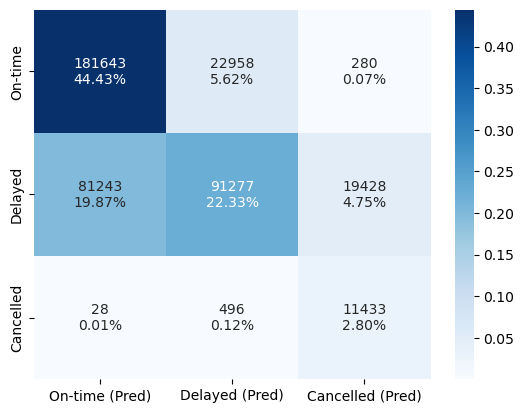

In [7]:
# Make labels for the heatmap

counts = [f'{val}' for val in cm.flatten()]
percents = [f'{val:.2%}' for val in cm.flatten()/np.sum(cm)]
labels = [f'{count}\n{percent}' for count, percent in zip(counts,percents)]

# Generate the heatmap with labels as 3x3 array

cm_heatmap = sns.heatmap(cm/np.sum(cm), annot=np.asarray(labels).reshape(3, 3),
                         fmt='', cmap='Blues',
                         xticklabels=['On-time (Pred)', 'Delayed (Pred)', 'Cancelled (Pred)'],
                         yticklabels=['On-time', 'Delayed', 'Cancelled'])

# Save heatmap to Resources/images
heatmap_path = Path('Resources/images/confusion_matrix_heatmap.png')
cm_heatmap.get_figure().savefig(heatmap_path)